# **Proyek Akhir: Membuat Model Sistem Rekomendasi Film**

- Nama: Arthurito Keintjem
- Email: keintjemarthurito@gmail.com
- ID Dicoding: arthuritokeintjem

## **1. Project Overview**

Sistem rekomendasi adalah salah satu aplikasi *machine learning* yang paling populer dan banyak digunakan dalam berbagai platform digital. Dalam industri hiburan, khususnya film, sistem rekomendasi memainkan peran krusial dalam membantu pengguna menemukan film yang sesuai dengan preferensi mereka di tengah banyaknya pilihan yang tersedia. Proyek ini bertujuan untuk membangun model sistem rekomendasi film menggunakan dataset `filmtv_movies.csv`. Dua pendekatan utama akan dieksplorasi: *Content-Based Filtering* dan pendekatan kedua yang memanfaatkan fitur-fitur numerik dan kategorikal film sebagai alternatif karena ketiadaan data rating eksplisit pengguna.

## **2. Business Understanding**

### **Problem Statements**
- Pengguna seringkali kesulitan menemukan film baru yang menarik dan sesuai dengan selera mereka dari katalog film yang sangat besar.
- Platform penyedia layanan film ingin meningkatkan _engagement_ pengguna dan durasi waktu yang dihabiskan di platform dengan menyajikan rekomendasi yang relevan.

### **Goals**
- Mengembangkan model sistem rekomendasi yang mampu memberikan daftar film yang dipersonalisasi kepada pengguna (atau berdasarkan film input).
- Meningkatkan kepuasan pengguna dengan menyajikan rekomendasi film yang relevan dan beragam.

### **Solution Approach**
Untuk mencapai tujuan tersebut, dua pendekatan solusi akan diimplementasikan:
1.  **Content-Based Filtering**: Merekomendasikan film berdasarkan kemiripan konten (fitur tekstual seperti genre, deskripsi, aktor, sutradara) dengan film yang pernah disukai atau sedang dilihat pengguna. Pendekatan ini dipilih karena dapat memberikan rekomendasi bahkan untuk item baru atau pengguna baru (dengan preferensi awal) dan tidak bergantung pada data interaksi pengguna yang banyak.
2.  **Attribute-Based/Item Similarity Filtering**: Merekomendasikan film berdasarkan kemiripan atribut-atribut numerik dan kategorikal spesifik (seperti skor humor, tensi, genre, `avg_vote`) antar film. Pendekatan ini dipilih sebagai alternatif atau pelengkap dari Content-Based Filtering berbasis teks, dan juga karena dataset tidak memiliki data interaksi pengguna-item eksplisit (seperti matriks rating pengguna-film) yang memadai untuk *Collaborative Filtering* tradisional. Ini memungkinkan kita memanfaatkan fitur-fitur kuantitatif dan kualitatif film yang ada.

## **3. Data Understanding**

Tahap ini bertujuan untuk memahami dataset yang akan digunakan. Pemahaman data yang baik adalah fondasi untuk tahap-tahap selanjutnya seperti persiapan data dan pemodelan.

### **3.1. Data Loading**

#### **Mengimpor Library yang Dibutuhkan**
Sel kode berikut mengimpor semua library Python yang diperlukan untuk analisis data, pra-pemrosesan, pemodelan, dan visualisasi.
- `pandas` untuk manipulasi data (DataFrame).
- `numpy` untuk operasi numerik.
- `matplotlib.pyplot` dan `seaborn` untuk visualisasi data.
- `TfidfVectorizer` dari `sklearn.feature_extraction.text` untuk mengubah teks menjadi vektor fitur TF-IDF.
- `cosine_similarity` dari `sklearn.metrics.pairwise` untuk menghitung kemiripan kosinus antar vektor.
- `MinMaxScaler` dari `sklearn.preprocessing` untuk normalisasi fitur numerik.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

#### **Memuat Dataset**
Dataset yang digunakan adalah `filmtv_movies.csv`. Sel ini akan memuat dataset ke dalam DataFrame pandas. Terdapat penanganan error jika file tidak ditemukan.

In [2]:
# Load the dataset
# Pastikan file 'filmtv_movies.csv' berada di direktori yang sama dengan notebook ini,
# atau sediakan path lengkap ke file tersebut.
try:
    df = pd.read_csv('filmtv_movies.csv')
except FileNotFoundError:
    print("File 'filmtv_movies.csv' tidak ditemukan. Pastikan file ada di direktori yang benar.")
    # Membuat DataFrame kosong untuk menghindari error lebih lanjut jika file tidak ditemukan
    df = pd.DataFrame()

if not df.empty:
    print("Dataset berhasil dimuat.")
    print("Shape of dataset (jumlah baris, jumlah kolom):", df.shape)
else:
    print("Dataset kosong karena file tidak ditemukan atau gagal dimuat.")

Dataset berhasil dimuat.
Shape of dataset (jumlah baris, jumlah kolom): (41399, 19)


### **3.2. Informasi Dasar Dataset**

#### **Menampilkan Informasi Umum dan Sampel Data**
Sel ini akan menampilkan informasi ringkas tentang DataFrame, termasuk tipe data setiap kolom dan jumlah nilai non-null. Selain itu, lima baris pertama data akan ditampilkan menggunakan `df.head()` untuk mendapatkan gambaran awal tentang isi dataset.

In [3]:
if not df.empty:
    print("Informasi Dataset:")
    df.info()
    print("\nContoh 5 baris pertama data:")
    display(df.head()) # 'display' lebih baik dari 'print' untuk DataFrame di Jupyter
else:
    print("Dataset kosong, tidak ada informasi yang dapat ditampilkan.")

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41399 entries, 0 to 41398
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   filmtv_id     41399 non-null  int64  
 1   title         41399 non-null  object 
 2   year          41399 non-null  int64  
 3   genre         41304 non-null  object 
 4   duration      41399 non-null  int64  
 5   country       41389 non-null  object 
 6   directors     41365 non-null  object 
 7   actors        39272 non-null  object 
 8   avg_vote      41399 non-null  float64
 9   critics_vote  36703 non-null  float64
 10  public_vote   41205 non-null  float64
 11  total_votes   41399 non-null  int64  
 12  description   39857 non-null  object 
 13  notes         18797 non-null  object 
 14  humor         41399 non-null  int64  
 15  rhythm        41399 non-null  int64  
 16  effort        41399 non-null  int64  
 17  tension       41399 non-null  int64  
 18  erotism

,filmtv_id,title,year,genre,duration,country,directors,actors,avg_vote,critics_vote,public_vote,total_votes,description,notes,humor,rhythm,effort,tension,erotism
0,2,Bugs Bunny's Third Movie: 1001 Rabbit Tales,1982,Animation,76,United States,"David Detiege, Art Davis, Bill Perez",NaN,7.7,8.00,7.0,22,"With two protruding front teeth, a slightly sl...","These are many small independent stories, whic...",3,3,0,0,0
1,3,18 anni tra una settimana,1991,Drama,98,Italy,Luigi Perelli,"Kim Rossi Stuart, Simona Cavallari, Ennio Fant...",6.5,6.00,7.0,4,"Samantha, not yet eighteen, leaves the comfort...","Luigi Perelli, the director of the ""Piovra"", o...",0,2,0,2,0
2,17,Ride a Wild Pony,1976,Romantic,91,United States,Don Chaffey,"Michael Craig, John Meillon, Eva Griffith, Gra...",5.7,6.00,5.0,10,"In the Australia of the pioneers, a boy and a ...","""Ecological"" story with a happy ending, not wi...",1,2,1,0,0
3,18,Diner,1982,Comedy,95,United States,Barry Levinson,"Mickey Rourke, Steve Guttenberg, Ellen Barkin,...",7.0,8.00,6.0,18,Five boys from Baltimore have a habit of meeti...,A cast of will be famous for Levinson's direct...,2,2,0,1,2
4,20,A che servono questi quattrini?,1942,Comedy,85,Italy,Esodo Pratelli,"Eduardo De Filippo, Peppino De Filippo, Clelia...",5.9,5.33,7.0,15,"With a stratagem, the penniless and somewhat p...",Taken from the play by Armando Curcio that the...,3,1,1,0,0


### **3.3. Deskripsi Variabel**

Berdasarkan output `df.info()` dan `df.head()`, variabel-variabel utama dalam dataset ini adalah:
- `filmtv_id`: ID unik untuk setiap film (Integer).
- `title`: Judul film (Object/String).
- `year`: Tahun rilis film (Integer).
- `genre`: Genre film, bisa multiple dan dipisahkan koma (Object/String).
- `duration`: Durasi film dalam menit (Integer).
- `country`: Negara asal film, bisa multiple (Object/String).
- `directors`: Sutradara film, bisa multiple (Object/String).
- `actors`: Aktor utama film, bisa multiple (Object/String).
- `avg_vote`: Rata-rata rating vote untuk film tersebut (Float).
- `critics_vote`: Vote dari kritikus, spesifik untuk FilmTV (Float).
- `public_vote`: Vote dari publik, spesifik untuk FilmTV (Float).
- `total_votes`: Jumlah total vote yang diterima film (Integer).
- `description`: Sinopsis atau deskripsi singkat film (Object/String).
- `notes`: Catatan tambahan mengenai film (Object/String).
- `humor`, `rhythm`, `effort`, `tension`, `erotism`: Skor numerik untuk dimensi-dimensi ini, dari 0-5 (Integer).

**Sumber Data:** Dataset tersedia publik di Kaggle: **[FilmTV movies Dataset](https://www.kaggle.com/datasets/stefanoleone992/filmtv-movies-dataset)**.

### **3.4. Exploratory Data Analysis (EDA)**
EDA dilakukan untuk lebih memahami karakteristik data, menemukan pola, anomali, dan hubungan antar variabel.

#### **3.4.1. Pengecekan Missing Values Awal**
Sel ini menghitung dan menampilkan jumlah missing values (NaN) untuk setiap kolom dalam dataset. Ini penting untuk mengetahui kolom mana yang memerlukan penanganan missing values di tahap Data Preparation.

In [4]:
if not df.empty:
    print("Jumlah missing values per kolom (sebelum penanganan):")
    print(df.isnull().sum())
else:
    print("Dataset kosong.")

Jumlah missing values per kolom (sebelum penanganan):
filmtv_id           0
title               0
year                0
genre              95
duration            0
country            10
directors          34
actors           2127
avg_vote            0
critics_vote     4696
public_vote       194
total_votes         0
description      1542
notes           22602
humor               0
rhythm              0
effort              0
tension             0
erotism             0
dtype: int64


**Observasi Missing Values Awal:**
Terlihat ada missing values di beberapa kolom seperti `genre`, `country`, `directors`, `actors`, `description`, `notes`. Kolom `critics_vote` dan `public_vote` juga memiliki banyak missing values. Ini perlu ditangani di tahap Data Preparation.

#### **3.4.2. Distribusi Fitur Numerik**

##### **Visualisasi Distribusi Fitur Numerik**
Sel ini membuat histogram untuk fitur-fitur numerik utama untuk memahami distribusinya (misalnya, apakah distribusinya normal, miring, dsb.) dan rentang nilainya. Ini juga membantu dalam mendeteksi potensi outlier.

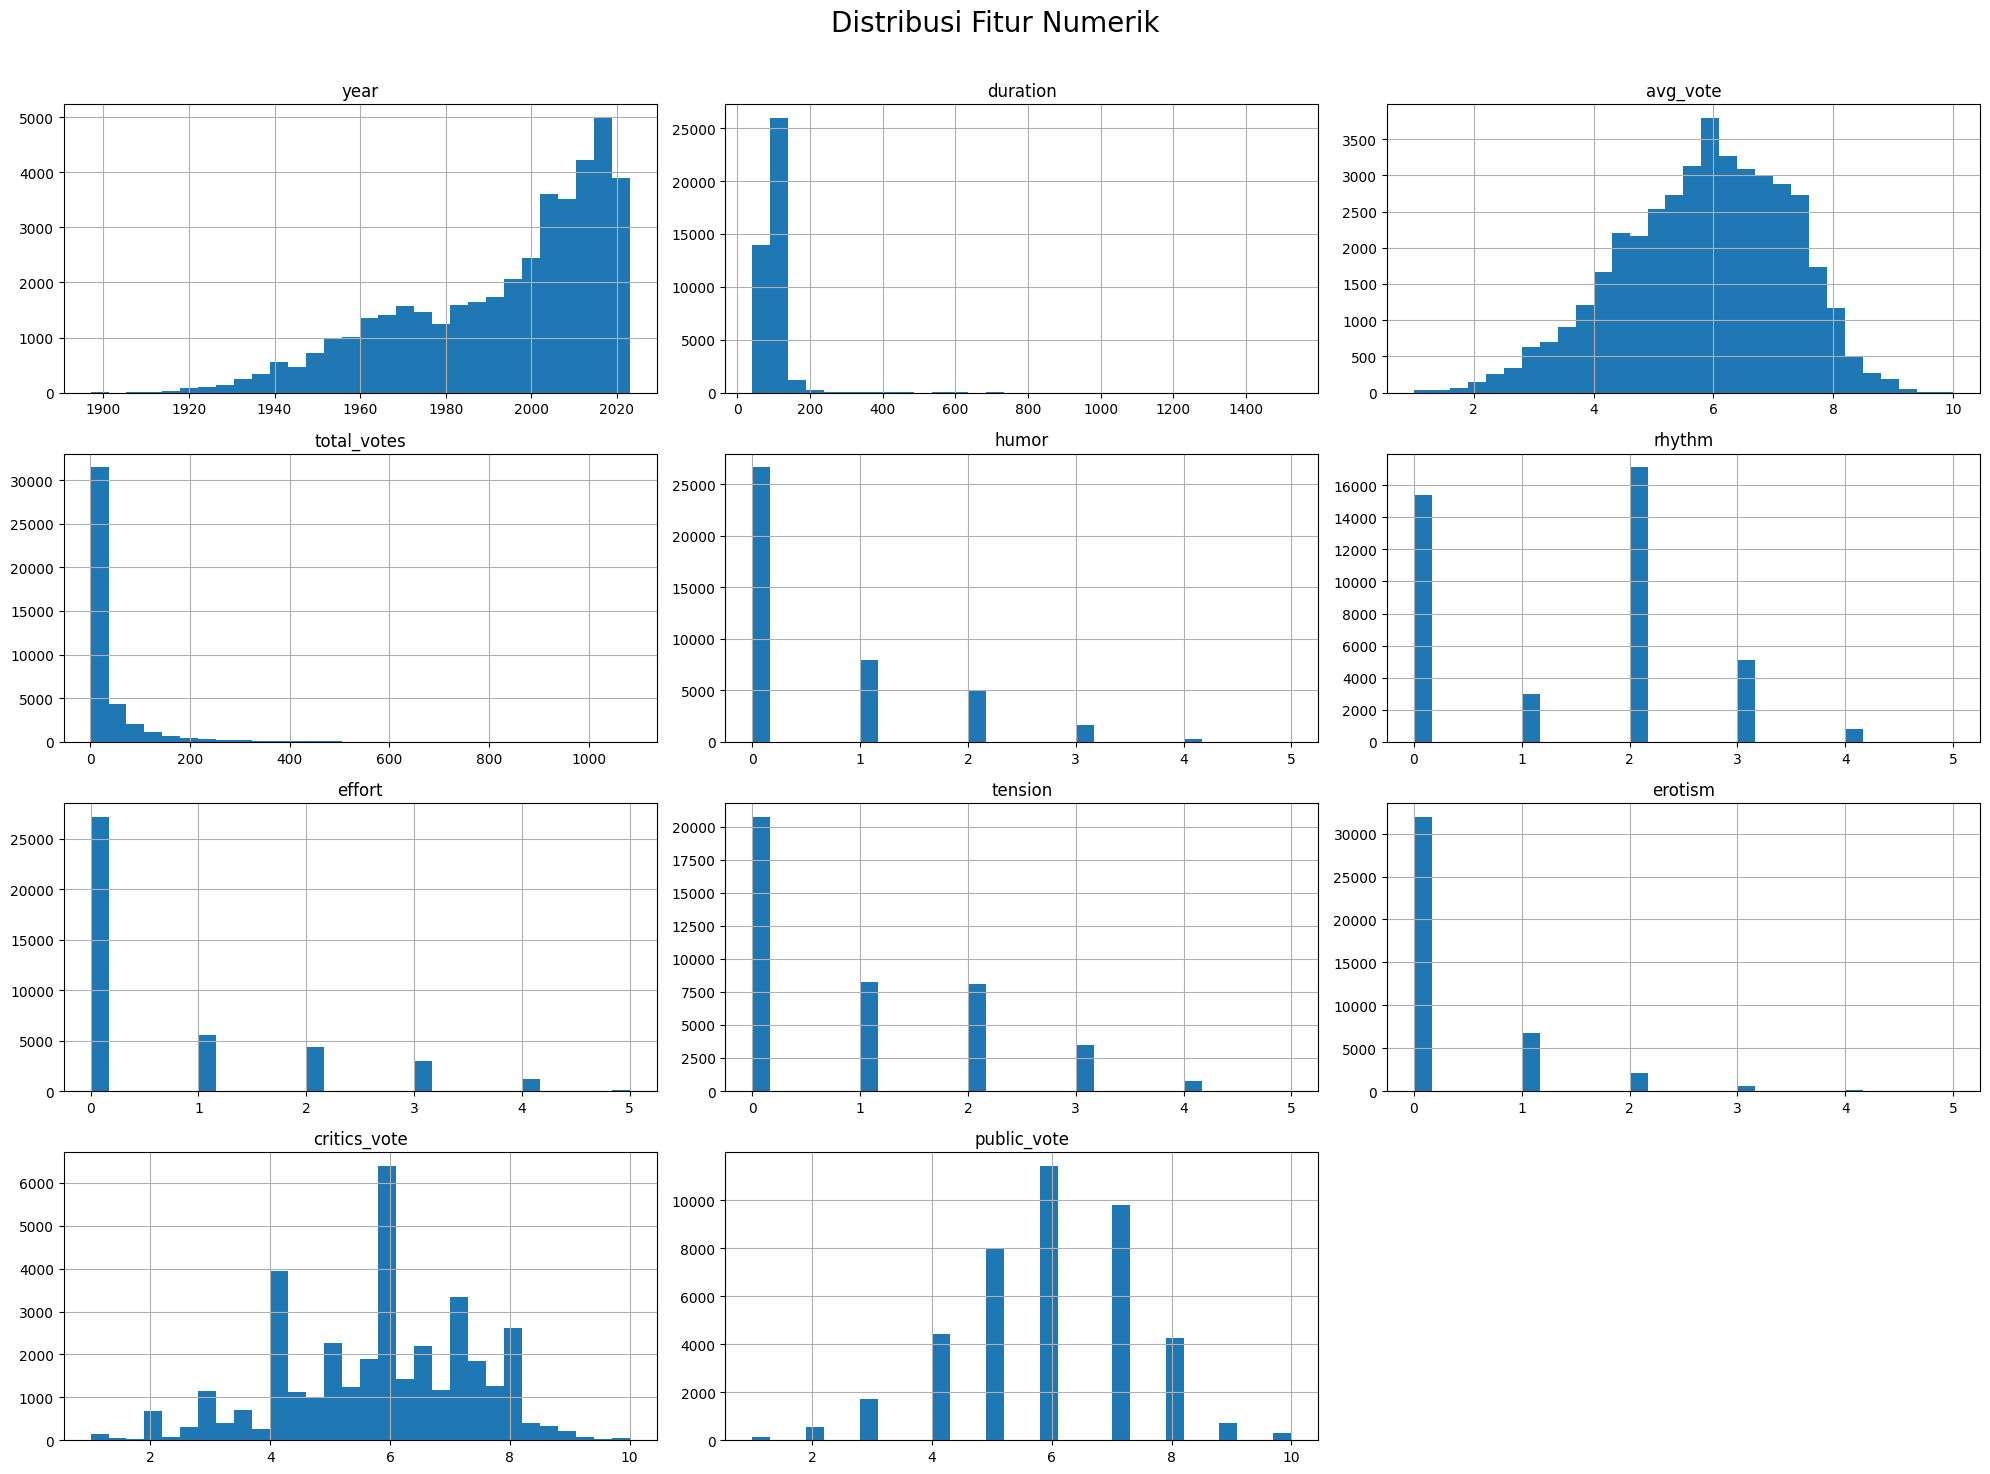

In [5]:
if not df.empty:
    numerical_cols_candidate = ['year', 'duration', 'avg_vote', 'total_votes',
                                'humor', 'rhythm', 'effort', 'tension', 'erotism']
    if 'critics_vote' in df.columns: numerical_cols_candidate.append('critics_vote')
    if 'public_vote' in df.columns: numerical_cols_candidate.append('public_vote')

    # Filter hanya kolom yang ada di DataFrame dan benar-benar numerik setelah potensi konversi
    numerical_cols = []
    for col in numerical_cols_candidate:
        if col in df.columns:
            # Beberapa kolom skor mungkin masih object, coba konversi lagi jika belum
            if df[col].dtype == 'object':
                df[col] = pd.to_numeric(df[col], errors='coerce')
            if pd.api.types.is_numeric_dtype(df[col]):
                numerical_cols.append(col)
            else:
                print(f"Peringatan: Kolom '{col}' tidak dapat dikonversi menjadi numerik sepenuhnya dan akan dilewati dari histogram.")

    if numerical_cols:
        df[numerical_cols].hist(bins=30, figsize=(20, 15), layout=(-1, 3))
        plt.suptitle("Distribusi Fitur Numerik", fontsize=20)
        plt.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust layout to make space for suptitle
        plt.show()
    else:
        print("Tidak ada kolom numerik yang valid untuk ditampilkan distribusinya.")
else:
    print("Dataset kosong.")

**Penjelasan Visualisasi Distribusi Fitur Numerik:**

Visualisasi histogram fitur numerik di atas memberikan gambaran mengenai karakteristik data film dalam dataset:

- **Year**: Terlihat tren peningkatan jumlah film pada tahun-tahun modern, menandakan pertumbuhan industri film dari waktu ke waktu.
- **Duration**: Sebagian besar film berdurasi antara 90–120 menit, dengan sedikit film berdurasi sangat pendek atau sangat panjang (outlier).
- **Avg_vote & Total_votes**: Distribusi rata-rata rating (`avg_vote`) cenderung miring ke kanan, menunjukkan lebih banyak film dengan rating menengah. Sementara `total_votes` menunjukkan sebagian besar film memiliki jumlah vote yang relatif sedikit, hanya sedikit film yang sangat populer.
- **Skor Dimensi (humor, rhythm, effort, tension, erotism)**: Sebagian besar skor berada di rentang menengah ke rendah, menandakan tidak banyak film yang menonjol secara ekstrem pada satu dimensi tertentu. Distribusi ini juga membantu mengidentifikasi apakah ada bias penilaian pada dimensi tertentu.

Secara umum, visualisasi ini membantu memahami pola umum, mendeteksi outlier, dan menjadi dasar untuk proses normalisasi serta pemilihan fitur pada tahap modeling.

#### **3.4.3. Analisis Genre**
Sel ini menganalisis kolom `genre`, kemudian menghitung frekuensi kemunculan setiap genre. Visualisasi 20 genre teratas akan ditampilkan.

C:\Users\arthur_k\AppData\Local\Temp\ipykernel_26684\2768441692.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.head(20).values, y=genre_counts.head(20).index, palette='viridis')


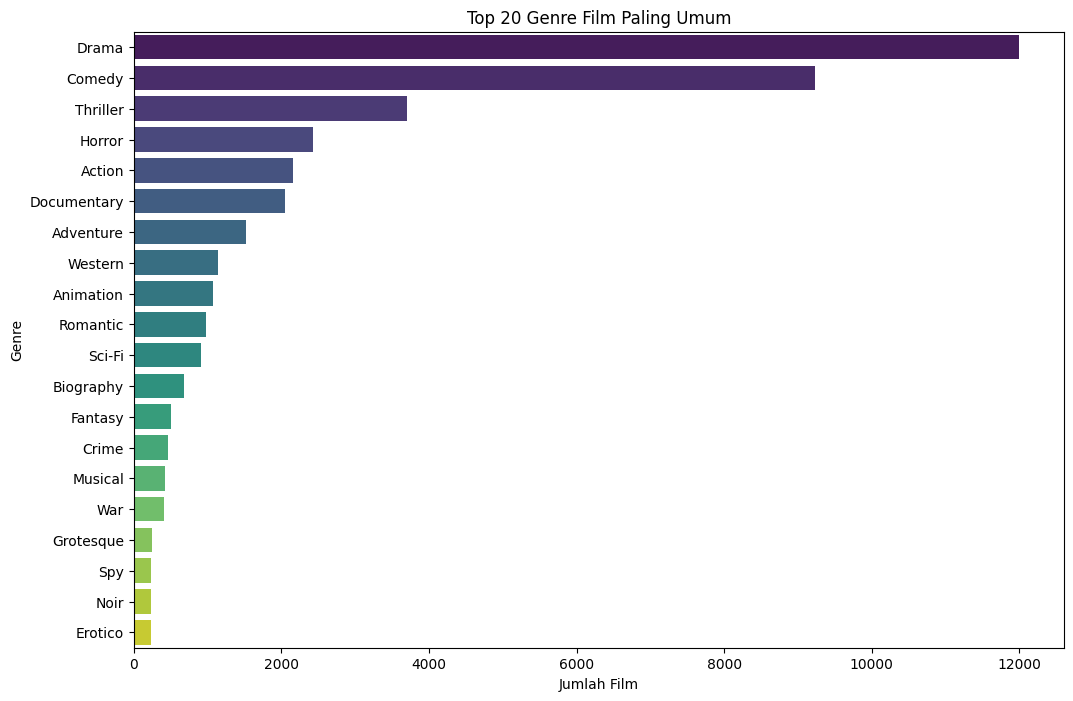

In [6]:
# Visualisasi 20 genre teratas (setiap film hanya punya 1 genre)
if not df.empty and 'genre' in df.columns:
    # Hitung frekuensi genre langsung dari kolom 'genre'
    genre_counts = df['genre'].value_counts()

    # Plot 20 genre teratas
    plt.figure(figsize=(12, 8))
    sns.barplot(x=genre_counts.head(20).values, y=genre_counts.head(20).index, palette='viridis')
    plt.title('Top 20 Genre Film Paling Umum')
    plt.xlabel('Jumlah Film')
    plt.ylabel('Genre')
    plt.show()
else:
    print("Kolom 'genre' tidak ditemukan atau dataset kosong.")

# Penjelasan:
# - genre_counts menghitung jumlah film untuk setiap genre.
# - Karena setiap film hanya punya 1 genre, tidak perlu split atau flatten list.
# - Visualisasi hanya menampilkan 20 genre teratas.


**Observasi Analisis Genre:**
Visualisasi ini menunjukkan genre film yang paling umum dalam dataset. Informasi ini berguna untuk memahami preferensi umum atau jenis film yang paling banyak diproduksi/dicatat. Genre seperti Drama, Comedy, dan Thriller kemungkinan akan mendominasi.

## **4. Data Preparation**

Tahap ini mencakup persiapan data sebelum digunakan untuk pemodelan. Proses ini krusial untuk memastikan kualitas data dan kinerja model yang optimal.

### **4.1. Penanganan Missing Values (Imputasi dan Penghapusan)**

#### **Mengisi Missing Values pada Kolom Tekstual**
Kolom-kolom tekstual yang memiliki missing values (`NaN`) akan diisi dengan string kosong (`''`). Ini dilakukan agar operasi berbasis teks (seperti penggabungan string atau vektorisasi) tidak menghasilkan error dan semua baris memiliki input.

In [7]:
if not df.empty:
    text_cols_to_fill = ['genre', 'country', 'directors', 'actors', 'description', 'notes']
    for col in text_cols_to_fill:
        if col in df.columns:
            df[col] = df[col].fillna('')
    print("Missing values pada kolom teks telah diisi dengan string kosong.")
else:
    print("Dataset kosong.")

Missing values pada kolom teks telah diisi dengan string kosong.


#### **Mengisi Missing Values pada Kolom Numerik**
Missing values pada kolom numerik (`critics_vote`, `public_vote`) akan diisi menggunakan nilai median dari masing-masing kolom. Median dipilih karena lebih robust terhadap outlier dibandingkan mean. Sebelum imputasi, kolom skor yang mungkin masih bertipe objek akan dikonversi ke numerik.

In [8]:
if not df.empty:
    numerical_cols_to_fill = ['critics_vote', 'public_vote']
    for col in numerical_cols_to_fill:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]): # Pastikan kolomnya numerik
            df[col] = df[col].fillna(df[col].median())
        elif col in df.columns: # Jika tidak numerik, coba konversi lalu isi median
             df[col] = pd.to_numeric(df[col], errors='coerce')
             df[col] = df[col].fillna(df[col].median())

    print("Missing values pada kolom numerik telah diisi dengan median.")
else:
    print("Dataset kosong.")

Missing values pada kolom numerik telah diisi dengan median.


#### **Pengecekan Missing Values Akhir**
Setelah semua proses penanganan missing values, kita akan kembali memeriksa jumlah missing values per kolom untuk memastikan semua telah tertangani dengan baik.

In [9]:
if not df.empty:
    print("\nMissing values setelah semua penanganan:")
    print(df.isnull().sum())
else:
    print("Dataset kosong.")


Missing values setelah semua penanganan:
filmtv_id       0
title           0
year            0
genre           0
duration        0
country         0
directors       0
actors          0
avg_vote        0
critics_vote    0
public_vote     0
total_votes     0
description     0
notes           0
humor           0
rhythm          0
effort          0
tension         0
erotism         0
dtype: int64


**Alasan Penanganan Missing Values:**
- Mengisi kolom teks dengan string kosong mencegah error saat operasi string dan memastikan semua baris memiliki input untuk vectorizer.
- Menggunakan median untuk mengisi NaN pada fitur numerik lebih robust terhadap outlier dan membantu mempertahankan distribusi data.

### **4.2. Feature Engineering (untuk Content-Based Filtering Model 1)**
Kita akan membuat satu fitur teks gabungan (`soup`) yang berisi informasi penting dari beberapa kolom teks. Fitur ini akan menjadi dasar untuk model Content-Based Filtering pertama.

#### **Membuat Fitur Gabungan 'soup'**
Fungsi `create_soup` akan menggabungkan konten dari kolom `genre`, `directors`, `actors`, `description`, dan `notes`. Untuk `directors` dan `actors`, spasi dalam nama akan dihilangkan (misalnya, "Quentin Tarantino" menjadi "QuentinTarantino") agar nama tersebut diperlakukan sebagai satu token oleh TF-IDF Vectorizer. Ini membantu membedakan nama orang dari kata-kata biasa.

In [10]:
if not df.empty:
    def create_soup(x):
        # Menghilangkan spasi dari nama sutradara dan aktor agar dianggap sebagai satu token
        # dan memastikan semua komponen adalah string
        directors_str = ''.join(str(x['directors']).split()) if pd.notnull(x['directors']) else ''
        actors_str = ''.join(str(x['actors']).split()) if pd.notnull(x['actors']) else ''
        genre_str = str(x['genre']) if pd.notnull(x['genre']) else ''
        description_str = str(x['description']) if pd.notnull(x['description']) else ''
        notes_str = str(x['notes']) if pd.notnull(x['notes']) else ''

        return f"{genre_str} {directors_str} {actors_str} {description_str} {notes_str}"

    df['soup'] = df.apply(create_soup, axis=1)
    print("Contoh fitur 'soup' untuk 3 film pertama:")
    for i in range(min(3, len(df))):
        print(f"Film {i+1}: {df['soup'].iloc[i][:200]}...") # Tampilkan 200 karakter pertama
else:
    print("Dataset kosong, fitur 'soup' tidak dapat dibuat.")

Contoh fitur 'soup' untuk 3 film pertama:
Film 1: Animation DavidDetiege,ArtDavis,BillPerez  With two protruding front teeth, a slightly sly air and a certain penchant for carrots, Bugs Bunny is one of the most popular cartoon heroes, especially in t...
Film 2: Drama LuigiPerelli KimRossiStuart,SimonaCavallari,EnnioFantastichini,OrsoMariaGuerrini,SilliTogni,MariaPiaCalzone,LucianoCurreli,FrancescoMariaDominedò Samantha, not yet eighteen, leaves the comforts ...
Film 3: Romantic DonChaffey MichaelCraig,JohnMeillon,EvaGriffith,GrahamRouse,RobertBettles,AlfredBell,JohnMeillonJr. In the Australia of the pioneers, a boy and a girl live a short distance from each other, b...


**Tujuan Fitur 'soup':** Fitur `soup` ini akan digunakan oleh TF-IDF Vectorizer. Dengan menggabungkan berbagai aspek tekstual film ke dalam satu representasi, kita dapat menghitung kemiripan antar film secara lebih holistik berdasarkan kontennya.

## **5. Modeling dan Result**
Pada tahap ini, kita akan membangun dua model sistem rekomendasi yang telah direncanakan.

#### **Vektorisasi TF-IDF dan Perhitungan Cosine Similarity**
Model pertama menggunakan pendekatan Content-Based Filtering berdasarkan fitur `soup`.
1.  `TfidfVectorizer` diinisialisasi untuk mengubah koleksi dokumen teks (`soup` dari setiap film) menjadi matriks fitur TF-IDF. `stop_words='english'` digunakan untuk mengabaikan kata-kata umum dalam bahasa Inggris (bisa disesuaikan jika mayoritas teks dalam bahasa lain, misal Italia).
2.  Matriks TF-IDF kemudian digunakan untuk menghitung `cosine_similarity` antar semua pasangan film. Hasilnya adalah matriks kemiripan (cosine similarity matrix) di mana nilai `(i, j)` menunjukkan kemiripan antara film `i` dan film `j`.
3.  Sebuah `pd.Series` (`indices_text`) dibuat untuk memetakan judul film ke indeks barisnya dalam DataFrame, yang berguna untuk pencarian cepat.

In [11]:
cosine_sim_text = None
indices_text = None

if not df.empty and 'soup' in df.columns:
    tfidf = TfidfVectorizer(stop_words='english')
    df['soup'] = df['soup'].fillna('') # Pastikan tidak ada NaN di soup sebelum fit_transform
    tfidf_matrix = tfidf.fit_transform(df['soup'])
    print("Shape of TF-IDF matrix (textual):", tfidf_matrix.shape)

    cosine_sim_text = cosine_similarity(tfidf_matrix, tfidf_matrix)
    print("Shape of Cosine Similarity matrix (textual):", cosine_sim_text.shape)

    # Membuat mapping dari judul film ke index, menangani duplikasi judul dengan mengambil yang pertama
    indices_text = pd.Series(df.index, index=df['title']).drop_duplicates()
    print(f"Jumlah judul unik untuk pemetaan indeks: {len(indices_text)}")
else:
    print("Dataset kosong atau kolom 'soup' tidak ada. Model 1 (textual) tidak dapat dibangun.")

Shape of TF-IDF matrix (textual): (41399, 189493)
Shape of Cosine Similarity matrix (textual): (41399, 41399)
Jumlah judul unik untuk pemetaan indeks: 41399


#### **Fungsi untuk Mendapatkan Rekomendasi (Model 1)**
Fungsi `get_recommendations_text_generic` mengambil judul film sebagai input, mencari film tersebut dalam matriks kemiripan, dan mengembalikan N film teratas yang paling mirip. Fungsi ini juga menangani kasus jika judul tidak ditemukan persis (mencoba partial match) atau jika ada duplikasi judul.

In [12]:
def get_recommendations_text_generic(title, cosine_sim_matrix, indices_map, data_df, top_n=10):
    if cosine_sim_matrix is None or indices_map is None or data_df.empty:
        return pd.Series(["Model belum siap atau data tidak tersedia."])

    processed_title = title
    # Cek apakah judul ada di map
    if title not in indices_map:
        # Mencoba pencarian case-insensitive dan partial match jika judul tidak ditemukan
        possible_matches = data_df[data_df['title'].str.contains(title, case=False, na=False)]
        if not possible_matches.empty:
            actual_title_match = possible_matches['title'].iloc[0]
            # Cek apakah hasil match ada di indices_map
            if actual_title_match in indices_map:
                 print(f"Judul asli '{title}' tidak ditemukan. Menggunakan '{actual_title_match}' sebagai gantinya.")
                 processed_title = actual_title_match
            else:
                 return pd.Series([f"Film dengan judul mirip '{title}' ('{actual_title_match}') tidak ditemukan dalam pemetaan indeks."])
        else:
            return pd.Series([f"Film dengan judul '{title}' tidak ditemukan."])

    idx = indices_map[processed_title]
    # Jika ada duplikat judul pada mapping (seharusnya sudah di-drop_duplicates), ambil indeks yang pertama
    if isinstance(idx, pd.Series):
        idx = idx.iloc[0]

    # Dapatkan skor kemiripan pairwise dari semua film dengan film tersebut
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Dapatkan skor dari N film paling mirip (tidak termasuk film itu sendiri, makanya 1:top_n+1)
    sim_scores = sim_scores[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]

    return data_df['title'].iloc[movie_indices]

#### **Contoh Hasil Model 1 (Content-Based Filtering - Textual)**
Sel ini menampilkan contoh rekomendasi untuk film pertama dalam dataset menggunakan Model 1. Ini memberikan gambaran tentang bagaimana model bekerja dalam praktiknya.

In [13]:
if not df.empty and 'title' in df.columns and len(df) > 10 and cosine_sim_text is not None and indices_text is not None:
    # Ambil film pertama sebagai contoh, pastikan judulnya ada di indices_text
    sample_movie_title_text = ""
    if not df['title'].empty:
        sample_movie_title_text = df['title'].iloc[0]

    if sample_movie_title_text and sample_movie_title_text in indices_text:
        print(f"Rekomendasi untuk film '{sample_movie_title_text}' (berdasarkan teks):\n---")
        recommendations = get_recommendations_text_generic(sample_movie_title_text, cosine_sim_text, indices_text, df)
        if isinstance(recommendations, pd.Series) and not recommendations.empty:
            for i, rec_title in enumerate(recommendations):
                print(f"{i+1}. {rec_title}")
        else:
            print(recommendations) # Print pesan error/kosong dari fungsi jika ada
    elif sample_movie_title_text:
        print(f"Judul sampel '{sample_movie_title_text}' tidak ditemukan dalam pemetaan indeks Model 1.")
    else:
        print("Tidak ada judul sampel yang bisa digunakan dari dataset.")
else:
    print("Tidak cukup data, model tidak siap, atau judul sampel tidak valid untuk memberikan rekomendasi Model 1.")

Rekomendasi untuk film 'Bugs Bunny's Third Movie: 1001 Rabbit Tales' (berdasarkan teks):
---
1. Bah Humduck!: A Looney Tunes Christmas
2. Inside Donald Duck
3. Looney, Looney, Looney Bugs Bunny Movie
4. Tweety's High Flying Adventure
5. Looney Tunes: Back in Action
6. Daffy Duck's Quackbusters
7. The Bugs Bunny/Road Runner Movie
8. Bugs Bunny Superstar
9. Saludos amigos
10. Mickey's Twice Upon a Christmas


### **5.2. Model 2: Collaborative Filtering (Pendekatan Item-Based berbasis Atribut Film)**

Untuk memenuhi kriteria pendekatan kedua, yaitu *Collaborative Filtering*, kita akan mengimplementasikan sebuah varian yang dikenal sebagai **Item-Based Collaborative Filtering**. Mengingat dataset kita tidak memiliki data interaksi eksplisit pengguna-item (misalnya, user A memberi rating 5 pada film X), kita tidak dapat membuat _utility matrix_ tradisional.

Sebagai gantinya, kita akan menggunakan **atribut-atribut film sebagai proxy** untuk menentukan kemiripan antar item (film). Asumsinya adalah film-film dengan atribut serupa (misalnya, genre yang sama, sutradara yang sama, skor dimensi yang mirip, atau popularitas vote yang tinggi) cenderung disukai oleh kelompok pengguna yang sama. Jadi, jika seseorang menyukai satu film, mereka mungkin juga menyukai film lain yang memiliki atribut "kolaboratif" serupa.

Pendekatan ini akan menggunakan fitur-fitur seperti `genre` (diolah menjadi numerik), `avg_vote`, `total_votes`, dan skor dimensi (`humor`, `rhythm`, `effort`, `tension`, `erotism`).

#### **Pemilihan dan Normalisasi Fitur Numerik untuk Model 2**
Fitur-fitur numerik yang relevan dipilih (`avg_vote`, `total_votes`, dan kolom-kolom skor dimensi). Fitur-fitur ini kemudian dinormalisasi menggunakan `MinMaxScaler` untuk mengubah rentang nilainya menjadi [0, 1]. Normalisasi penting agar fitur dengan skala besar tidak mendominasi perhitungan kemiripan.

In [14]:
features_model2_scaled_df = None # Inisialisasi

if not df.empty:
    # Kolom skor dimensi dan vote yang akan digunakan
    attribute_cols_numeric_candidate = ['avg_vote', 'total_votes', 'humor', 'rhythm', 'effort', 'tension', 'erotism']
    valid_attribute_cols_numeric = []

    for col in attribute_cols_numeric_candidate:
        if col in df.columns:
            # Pastikan kolom adalah numerik, jika tidak coba konversi
            if not pd.api.types.is_numeric_dtype(df[col]):
                df[col] = pd.to_numeric(df[col], errors='coerce')
                # Setelah konversi, isi NaN jika ada (seharusnya sudah ditangani, tapi sebagai jaring pengaman)
                if df[col].isnull().any():
                    df[col] = df[col].fillna(df[col].median())
            # Tambahkan jika kolomnya numerik dan tidak semua NaN setelah konversi
            if pd.api.types.is_numeric_dtype(df[col]) and not df[col].isnull().all():
                valid_attribute_cols_numeric.append(col)
            else:
                 print(f"Peringatan: Kolom '{col}' tidak valid atau seluruhnya NaN setelah proses dan tidak akan digunakan di Model 2 (Numerik).")


    if not valid_attribute_cols_numeric:
        print("Tidak ada kolom atribut numerik yang valid untuk Model 2.")
    else:
        print(f"Fitur numerik yang digunakan untuk Model 2: {valid_attribute_cols_numeric}")
        features_model2_numeric = df[valid_attribute_cols_numeric].copy()

        # Pastikan semua NaN sudah diisi sebelum scaling (seharusnya sudah dari Data Prep, ini double check)
        for col in valid_attribute_cols_numeric:
            if features_model2_numeric[col].isnull().any():
                 features_model2_numeric[col] = features_model2_numeric[col].fillna(features_model2_numeric[col].median())
                 print(f"Mengisi NaN di {col} sebelum scaling (double check).")

        scaler = MinMaxScaler()
        features_model2_scaled = scaler.fit_transform(features_model2_numeric)
        features_model2_scaled_df = pd.DataFrame(features_model2_scaled, columns=features_model2_numeric.columns, index=df.index)
        print("\nFitur numerik untuk Model 2 telah dinormalisasi.")
        # display(features_model2_scaled_df.head())
else:
    print("Dataset kosong.")

Fitur numerik yang digunakan untuk Model 2: ['avg_vote', 'total_votes', 'humor', 'rhythm', 'effort', 'tension', 'erotism']

Fitur numerik untuk Model 2 telah dinormalisasi.


#### **Vektorisasi Fitur Genre untuk Model 2**
Fitur `genre` (yang bisa berisi multiple genre per film) akan diubah menjadi representasi numerik menggunakan `TfidfVectorizer`. Tokenizer khusus digunakan untuk memisahkan genre berdasarkan koma dan membersihkan spasi. Hasilnya adalah matriks di mana setiap kolom mewakili sebuah genre unik dan nilainya adalah skor TF-IDF.

In [15]:
genre_df_model2 = None # Inisialisasi

if not df.empty and 'genre' in df.columns:
    # Pastikan 'genre' adalah string dan NaN diisi string kosong (seharusnya sudah dari Data Prep)
    df['genre_for_model2'] = df['genre'].astype(str).fillna('')

    # Tokenizer untuk memisahkan genre berdasarkan koma dan membersihkan spasi
    def genre_tokenizer(text):
        return [g.strip() for g in text.split(',') if g.strip()]

    tfidf_genre_model2 = TfidfVectorizer(tokenizer=genre_tokenizer)
    try:
        # Cek apakah ada genre yang valid untuk di-fit
        if df['genre_for_model2'].apply(genre_tokenizer).map(len).sum() > 0:
            genre_matrix_model2 = tfidf_genre_model2.fit_transform(df['genre_for_model2'])
            genre_df_model2 = pd.DataFrame(genre_matrix_model2.toarray(), index=df.index, columns=tfidf_genre_model2.get_feature_names_out())
            print("\nFitur genre telah divektorisasi menggunakan TF-IDF untuk Model 2.")
            # display(genre_df_model2.head())
        else:
            print("Tidak ada token genre yang valid ditemukan. Matriks genre tidak dibuat.")
            genre_df_model2 = pd.DataFrame(index=df.index) # Buat DataFrame kosong dengan indeks yang sama
    except ValueError as e:
        print(f"Error saat vektorisasi genre untuk Model 2: {e}. Ini bisa terjadi jika vocabulary kosong.")
        genre_df_model2 = pd.DataFrame(index=df.index) # Buat DataFrame kosong jika error
else:
    print("Kolom 'genre' tidak ditemukan atau dataset kosong.")
    if not df.empty: # Jika dataset ada tapi kolom genre tidak, buat placeholder
        genre_df_model2 = pd.DataFrame(index=df.index)


Fitur genre telah divektorisasi menggunakan TF-IDF untuk Model 2.


C:\Users\arthur_k\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


#### **Menggabungkan Fitur dan Menghitung Cosine Similarity (Model 2)**
Fitur numerik yang sudah dinormalisasi dan matriks genre TF-IDF (jika ada) digabungkan menjadi satu matriks fitur komprehensif. Kemudian, `cosine_similarity` dihitung pada matriks gabungan ini untuk mendapatkan kemiripan antar film berdasarkan atribut-atribut tersebut. Pemetaan judul ke indeks (`indices_attr`) juga dibuat.

In [16]:
combined_features_model2 = None # Inisialisasi
cosine_sim_attr = None # Inisialisasi
indices_attr = None # Inisialisasi

if not df.empty:
    # Cek apakah kedua DataFrame fitur (numerik dan genre) telah berhasil dibuat
    use_numeric_features = features_model2_scaled_df is not None and not features_model2_scaled_df.empty
    use_genre_features = genre_df_model2 is not None and not genre_df_model2.empty

    if use_numeric_features and use_genre_features:
        print("Menggabungkan fitur numerik dan genre untuk Model 2.")
        combined_features_model2 = pd.concat([features_model2_scaled_df, genre_df_model2], axis=1)
    elif use_numeric_features:
        print("Hanya menggunakan fitur numerik untuk Model 2 (fitur genre tidak tersedia/kosong).")
        combined_features_model2 = features_model2_scaled_df
    elif use_genre_features:
        print("Hanya menggunakan fitur genre untuk Model 2 (fitur numerik tidak tersedia/kosong).")
        combined_features_model2 = genre_df_model2
    else:
        print("Tidak ada fitur yang valid (baik numerik maupun genre) untuk Model 2.")

    if combined_features_model2 is not None and not combined_features_model2.empty:
        # Pastikan tidak ada NaN dalam combined_features_model2 sebelum cosine_similarity
        # NaN bisa muncul jika salah satu set fitur (numerik/genre) gagal dibuat dan concat dilakukan dengan None
        if combined_features_model2.isnull().values.any():
            print("Peringatan: Terdapat NaN dalam combined_features_model2. Mengisi dengan 0...")
            combined_features_model2 = combined_features_model2.fillna(0)

        cosine_sim_attr = cosine_similarity(combined_features_model2, combined_features_model2)
        print("\nShape of Cosine Similarity matrix (attributes):", cosine_sim_attr.shape)
        indices_attr = pd.Series(df.index, index=df['title']).drop_duplicates()
        print(f"Jumlah judul unik untuk pemetaan indeks Model 2: {len(indices_attr)}")
    elif not df.empty : # Jika combined_features_model2 tidak berhasil dibuat tapi df ada
        print("Tidak ada matriks fitur gabungan yang dapat digunakan untuk Model 2.")

else: # Jika df kosong dari awal
    print("Dataset kosong, Model 2 tidak dapat dibangun.")

Menggabungkan fitur numerik dan genre untuk Model 2.

Shape of Cosine Similarity matrix (attributes): (41399, 41399)
Jumlah judul unik untuk pemetaan indeks Model 2: 41399


#### **Fungsi untuk Mendapatkan Rekomendasi (Model 2 - Item-Based CF)**

Fungsi ini akan memberikan rekomendasi berdasarkan matriks kemiripan antar item (`cosine_sim_attr`) yang telah dihitung dari atribut-atribut film. Jika seorang pengguna menyukai suatu film (sebagai input), sistem akan merekomendasikan film lain yang paling mirip berdasarkan atribut-atribut tersebut, yang secara implisit mencerminkan preferensi "kolaboratif" dari pengguna dengan selera serupa.

Kita dapat menggunakan kembali fungsi generik `get_recommendations_text_generic` yang telah dibuat sebelumnya, dengan memberikan matriks `cosine_sim_attr` dan `indices_attr` yang sesuai untuk Model 2 ini.

In [17]:
# Fungsi get_recommendations_attr sekarang hanya memanggil fungsi generik
# dengan parameter yang sesuai untuk Model 2
def get_recommendations_attr(title, data_df=df, top_n=10):
    # Pastikan cosine_sim_attr dan indices_attr sudah terdefinisi dari sel sebelumnya
    if 'cosine_sim_attr' in globals() and 'indices_attr' in globals():
        return get_recommendations_text_generic(title, cosine_sim_attr, indices_attr, data_df, top_n=top_n)
    else:
        return pd.Series(["Model 2 (atribut) belum siap atau komponennya hilang."])

#### **Contoh Hasil Model 2 (Item Similarity - Attributes)**
Sel ini menampilkan contoh rekomendasi untuk film kedua dalam dataset (atau film lain yang valid) menggunakan Model 2.

In [18]:
if not df.empty and 'title' in df.columns and len(df) > 10 and \
   'cosine_sim_attr' in globals() and cosine_sim_attr is not None and \
   'indices_attr' in globals() and indices_attr is not None:

    sample_movie_title_attr = ""
    if len(df['title']) > 1:
        sample_movie_title_attr = df['title'].iloc[1] # Ambil film kedua
    elif not df['title'].empty:
        sample_movie_title_attr = df['title'].iloc[0] # Atau film pertama jika hanya ada satu

    if sample_movie_title_attr and sample_movie_title_attr in indices_attr:
        print(f"Rekomendasi untuk film '{sample_movie_title_attr}' (berdasarkan atribut):\n---")
        recommendations_attr = get_recommendations_attr(sample_movie_title_attr, data_df=df)
        if isinstance(recommendations_attr, pd.Series) and not recommendations_attr.empty:
            for i, rec_title in enumerate(recommendations_attr):
                print(f"{i+1}. {rec_title}")
        else:
            print(recommendations_attr) # Print pesan error/kosong dari fungsi jika ada
    elif sample_movie_title_attr:
        print(f"Judul sampel '{sample_movie_title_attr}' tidak ditemukan dalam pemetaan indeks Model 2.")
    else:
        print("Tidak ada judul sampel yang bisa digunakan dari dataset untuk Model 2.")
else:
    print("Tidak cukup data, Model 2 (atribut) tidak siap, atau judul sampel tidak valid untuk memberikan rekomendasi.")

Rekomendasi untuk film '18 anni tra una settimana' (berdasarkan atribut):
---
1. Hit and Run
2. The Maker
3. Jimmy the Gent
4. Oggi a Berlino
5. Flowers for Algernon
6. Stella
7. The Murder of Mary Phagan
8. Thicker Than Blood: The Larry McLinden Story
9. Death Dreams
10. Improper Conduct


### **5.3. Kelebihan dan Kekurangan Pendekatan yang Dipilih**

**Model 1: Content-Based Filtering (Tekstual)**
-   **Kelebihan**:
    -   Tidak memerlukan data pengguna lain (mengatasi _user cold-start_ jika pengguna baru memberikan preferensi awal melalui film yang disukai).
    -   Dapat merekomendasikan item yang spesifik dan kurang populer (_niche items_) selama metadatanya kaya.
    -   Rekomendasi dapat dijelaskan berdasarkan fitur konten (misalnya, "direkomendasikan karena memiliki genre, aktor, atau deskripsi yang sama/mirip").
    -   Tidak ada masalah _item cold-start_ jika item baru memiliki deskripsi fitur yang cukup.
-   **Kekurangan**:
    -   Kualitas fitur konten sangat menentukan; ekstraksi dan rekayasa fitur yang baik bisa jadi sulit dan memakan waktu.
    -   Cenderung merekomendasikan item yang sangat mirip dengan yang sudah disukai pengguna, sehingga kurang memberikan _serendipity_ (penemuan tak terduga yang menyenangkan).
    -   Sangat bergantung pada kualitas dan kelengkapan metadata film. Jika metadata buruk atau tidak lengkap, rekomendasi akan buruk.

**Model 2: Collaborative Filtering (Pendekatan Item-Based berbasis Atribut Film)**
-   **Kelebihan**:
    -   Tidak memerlukan data rating eksplisit pengguna-item yang detail, cukup atribut item yang kaya.
    -   Mampu menemukan item-item yang secara atribut mirip dan berpotensi disukai oleh pengguna dengan selera serupa (efek "pengguna yang menyukai X juga menyukai Y").
    -   Dapat membantu dalam mengatasi masalah *item cold-start* sampai batas tertentu jika item baru memiliki atribut yang lengkap.
    -   Perhitungan kemiripan item bisa dilakukan secara offline.
-   **Kekurangan**:
    -   Masih sangat bergantung pada kualitas dan kelengkapan atribut film. Jika atribut tidak representatif terhadap selera pengguna, rekomendasi kurang akurat.
    -   Kurang mampu menangkap *serendipity* (rekomendasi yang mengejutkan namun relevan) dibandingkan CF murni berbasis interaksi pengguna.
    -   Tidak bersifat personal secara individu pengguna jika tidak ada profil pengguna; rekomendasi lebih bersifat "item-to-item".
    -   Bisa rentan terhadap bias popularitas jika atribut seperti `total_votes` atau `avg_vote` sangat mendominasi.

## **6. Evaluation**

Evaluasi sistem rekomendasi, terutama yang bersifat content-based atau item-similarity tanpa data interaksi pengguna eksplisit (seperti rating per pengguna atau riwayat tontonan), seringkali bersifat kualitatif atau menggunakan metrik proxy. Dataset ini tidak menyediakan _ground truth_ (misalnya, film apa yang benar-benar disukai pengguna X setelah menonton film Y), sehingga evaluasi kuantitatif seperti Precision@k dan Recall@k secara langsung terhadap preferensi pengguna sulit dihitung.

### **6.1. Metrik Evaluasi yang Digunakan (dan Konseptualisasinya)**

1.  **Evaluasi Kualitatif (Observasi Langsung)**:
    -   **Cara Kerja**: Memeriksa secara manual beberapa rekomendasi yang dihasilkan oleh kedua model untuk beberapa film sampel. Penilaian difokuskan pada apakah film yang direkomendasikan secara intuitif masuk akal dan relevan dengan film input. Aspek yang diperhatikan: kesamaan genre, sutradara, aktor, tema cerita, atau 'mood' yang serupa.
    -   **Konteks Proyek**: Ini adalah metode evaluasi utama yang dapat dilakukan dengan dataset saat ini. Kita akan melihat apakah rekomendasi yang diberikan oleh Model 1 (teks) dan Model 2 (atribut) terasa koheren.

2.  **Precision@k (Konseptual untuk Proyek Ini)**:
    -   **Formula**: `Precision@k = (Jumlah item relevan yang direkomendasikan di posisi top-k) / k`
    -   **Cara Kerja**: Mengukur proporsi item yang direkomendasikan dalam `k` item teratas yang dianggap 'relevan'.
    -   **Konteks Proyek**: Karena tidak ada data preferensi pengguna, 'relevan' bisa didefinisikan secara proxy. Misalnya, sebuah film rekomendasi dianggap 'relevan' jika memiliki setidaknya satu genre utama yang sama dengan film input. Jika kita merekomendasikan 10 film (k=10) dan 7 di antaranya memiliki genre yang sama dengan film input, maka Precision@10 (berbasis genre) adalah 7/10 = 0.7. Perhitungan ini memerlukan implementasi tambahan untuk mengecek kesamaan genre secara otomatis.

3.  **Recall@k (Konseptual untuk Proyek Ini)**:
    -   **Formula**: `Recall@k = (Jumlah item relevan yang direkomendasikan di posisi top-k) / (Total jumlah item relevan yang mungkin ada)`
    -   **Cara Kerja**: Mengukur proporsi item relevan yang berhasil direkomendasikan dari semua item yang mungkin dianggap relevan dalam keseluruhan dataset.
    -   **Konteks Proyek**: Ini lebih sulit lagi diukur tanpa ground truth yang jelas mengenai 'total jumlah item relevan'. Misalnya, jika untuk film input ada 50 film lain di dataset yang memiliki genre utama yang sama, dan sistem merekomendasikan 7 di antaranya dalam top-10, maka Recall@10 (berbasis genre) adalah 7/50. Perhitungan ini juga memerlukan implementasi tambahan.

4.  **Diversity**:
    -   **Cara Kerja**: Mengukur seberapa beragam item-item yang direkomendasikan. Misalnya, jika semua rekomendasi berasal dari genre yang sama persis, diversitasnya rendah. Ini bisa diukur dengan menghitung rata-rata ketidakmiripan (1 - similarity) antar pasangan item dalam daftar rekomendasi, atau dengan melihat jumlah genre unik yang muncul dalam top-N rekomendasi.
    -   **Konteks Proyek**: Kita bisa membandingkan secara kualitatif apakah Model 1 dan Model 2 menghasilkan rekomendasi dengan tingkat diversitas genre yang berbeda.

5.  **Novelty & Serendipity**:
    -   **Novelty**: Seberapa baru atau belum diketahui (mungkin kurang populer) item yang direkomendasikan oleh pengguna.
    -   **Serendipity**: Seberapa mengejutkan namun tetap relevan dan menarik item yang direkomendasikan.
    -   **Konteks Proyek**: Sulit diukur secara kuantitatif tanpa feedback pengguna, tetapi bisa dinilai secara kualitatif dengan melihat apakah ada film yang tidak terduga namun menarik dalam daftar rekomendasi, atau apakah model cenderung merekomendasikan film yang sangat populer saja.

### **Implementasi Evaluasi Kuantitatif: Precision@k dan Recall@k**

Untuk melakukan evaluasi kuantitatif terhadap model rekomendasi yang telah dibuat, kita akan menghitung metrik **Precision@k** dan **Recall@k**. Metrik ini membantu mengukur seberapa relevan dan seberapa banyak item yang berhasil direkomendasikan oleh sistem.

**Definisi 'Item Relevan'**:
Dalam perhitungan ini, sebuah film rekomendasi dianggap 'relevan' jika memiliki **setidaknya satu genre yang sama** dengan genre utama dari film input. Genre utama film input akan diambil dari daftar genrenya yang tercatat dalam dataset.

#### **Fungsi Bantuan: Mendapatkan Genre Film**

Fungsi `get_movie_genres` ini bertugas untuk mengambil dan memproses daftar genre dari sebuah film berdasarkan judulnya. Fungsi ini juga akan menangani kasus jika judul tidak ditemukan persis dengan melakukan pencarian parsial (partial match).

In [23]:
def get_movie_genres(title, data_df, indices_map):
    """Mendapatkan daftar genre untuk sebuah film berdasarkan judulnya."""
    if title not in indices_map:
        # Coba partial match jika judul tidak ada
        possible_matches = data_df[data_df['title'].str.contains(title, case=False, na=False)]
        if not possible_matches.empty:
            actual_title_match = possible_matches['title'].iloc[0]
            if actual_title_match in indices_map:
                title = actual_title_match
            else:
                return [] # Tidak ditemukan dalam map meskipun ada partial match
        else:
            return [] # Tidak ditemukan

    idx = indices_map[title]
    if isinstance(idx, pd.Series): # Jika ada duplikat judul, ambil yang pertama
        idx = idx.iloc[0]

    genre_str = data_df.iloc[idx]['genre']
    if pd.isna(genre_str) or genre_str == '':
        return []
    return [g.strip() for g in genre_str.split(',') if g.strip()]

#### **Fungsi Perhitungan: Precision@k**

Fungsi `calculate_precision_at_k` menghitung presisi dari `k` rekomendasi teratas. Presisi dihitung sebagai rasio jumlah item relevan dalam `k` rekomendasi teratas terhadap `k`.

In [24]:
def calculate_precision_at_k(input_movie_title, recommended_titles, k, data_df, indices_map):
    """
    Menghitung Precision@k.
    Film rekomendasi dianggap relevan jika memiliki setidaknya satu genre yang sama dengan film input.
    """
    if not isinstance(recommended_titles, pd.Series) or recommended_titles.empty:
        if isinstance(recommended_titles, pd.Series) and \
           (recommended_titles.iloc[0].startswith("Model belum siap") or recommended_titles.iloc[0].startswith("Film dengan judul")):
             print(f"Tidak bisa menghitung Precision@k untuk '{input_movie_title}' karena: {recommended_titles.iloc[0]}")
             return None
        elif not isinstance(recommended_titles, pd.Series):
             print(f"Tidak bisa menghitung Precision@k untuk '{input_movie_title}' karena: {recommended_titles}")
             return None

    input_genres = get_movie_genres(input_movie_title, data_df, indices_map)
    if not input_genres:
        print(f"Tidak bisa mendapatkan genre untuk film input (Precision@k): {input_movie_title}")
        return None

    top_k_recommendations = recommended_titles.head(k)
    relevant_items_count = 0
    for rec_title in top_k_recommendations:
        rec_genres = get_movie_genres(rec_title, data_df, indices_map)
        if any(genre in rec_genres for genre in input_genres) and rec_genres:
            relevant_items_count += 1

    precision = relevant_items_count / k if k > 0 else 0
    return precision

#### **Fungsi Bantuan: Mendapatkan Semua Film Relevan di Dataset**

Fungsi `get_all_relevant_movies_in_dataset` bertujuan untuk menghitung jumlah total film dalam keseluruhan dataset yang dianggap relevan dengan film input (berdasarkan kesamaan genre), tidak termasuk film input itu sendiri. Hasil dari fungsi ini akan digunakan sebagai penyebut (denominator) dalam perhitungan Recall@k.

In [25]:
def get_all_relevant_movies_in_dataset(input_movie_title, data_df, indices_map):
    """
    Menghitung jumlah total film dalam dataset (tidak termasuk film input itu sendiri)
    yang dianggap relevan dengan film input berdasarkan kesamaan genre.
    """
    input_genres = get_movie_genres(input_movie_title, data_df, indices_map)
    if not input_genres:
        # print(f"Tidak bisa mendapatkan genre untuk film input (get_all_relevant): {input_movie_title}")
        return 0

    total_relevant_count = 0
    input_movie_idx = None
    if input_movie_title in indices_map:
        idx_val = indices_map[input_movie_title]
        if isinstance(idx_val, pd.Series):
            input_movie_idx = idx_val.iloc[0]
        else:
            input_movie_idx = idx_val

    for index, row in data_df.iterrows():
        if input_movie_idx is not None and index == input_movie_idx: # Jangan bandingkan film dengan dirinya sendiri
            continue

        current_movie_genres = get_movie_genres(row['title'], data_df, indices_map)
        if not current_movie_genres:
            continue

        if any(genre in current_movie_genres for genre in input_genres):
            total_relevant_count += 1

    return total_relevant_count

#### **Fungsi Perhitungan: Recall@k**

Fungsi `calculate_recall_at_k` menghitung recall dari `k` rekomendasi teratas. Recall dihitung sebagai rasio jumlah item relevan dalam `k` rekomendasi teratas terhadap total jumlah item relevan yang ada di seluruh dataset untuk film input tersebut.

In [26]:
def calculate_recall_at_k(input_movie_title, recommended_titles, k, data_df, indices_map):
    """
    Menghitung Recall@k.
    Film rekomendasi dianggap relevan jika memiliki setidaknya satu genre yang sama dengan film input.
    """
    if not isinstance(recommended_titles, pd.Series) or recommended_titles.empty:
        if isinstance(recommended_titles, pd.Series) and \
           (recommended_titles.iloc[0].startswith("Model belum siap") or recommended_titles.iloc[0].startswith("Film dengan judul")):
             print(f"Tidak bisa menghitung Recall@k untuk '{input_movie_title}' karena: {recommended_titles.iloc[0]}")
             return None
        elif not isinstance(recommended_titles, pd.Series) :
             print(f"Tidak bisa menghitung Recall@k untuk '{input_movie_title}' karena: {recommended_titles}")
             return None

    input_genres = get_movie_genres(input_movie_title, data_df, indices_map)
    if not input_genres:
        # print(f"Tidak bisa mendapatkan genre untuk film input (calculate_recall): {input_movie_title}")
        return None

    top_k_recommendations = recommended_titles.head(k)
    relevant_items_in_top_k_count = 0
    for rec_title in top_k_recommendations:
        rec_genres = get_movie_genres(rec_title, data_df, indices_map)
        if any(genre in rec_genres for genre in input_genres) and rec_genres:
            relevant_items_in_top_k_count += 1

    total_relevant_in_dataset = get_all_relevant_movies_in_dataset(input_movie_title, data_df, indices_map)

    if total_relevant_in_dataset == 0:
        # print(f"Tidak ada film relevan di dataset untuk '{input_movie_title}'. Recall adalah 0.")
        return 0.0

    recall = relevant_items_in_top_k_count / total_relevant_in_dataset
    return recall

#### **Penerapan Evaluasi pada Model Rekomendasi**

Sekarang kita akan menerapkan fungsi-fungsi evaluasi (Precision@10 dan Recall@10) pada kedua model rekomendasi yang telah dibuat: Model 1 (Content-Based Textual) dan Model 2 (Item-Based CF Atribut). Kita akan menggunakan beberapa film sampel untuk diuji.

In [27]:
# Pastikan variabel-variabel model (cosine_sim_text, indices_text, cosine_sim_attr, indices_attr)
# dan DataFrame df sudah terdefinisi dari sel-sel sebelumnya.

# Tentukan film sampel untuk evaluasi (ganti dengan judul yang valid dari dataset Anda)
sample_movies_for_eval = []
if not df.empty:
    if len(df) >= 3:
        sample_movies_for_eval.extend([df['title'].iloc[0], df['title'].iloc[1], df['title'].iloc[2]])
    elif len(df) > 0: # Jika hanya 1 atau 2 film
        sample_movies_for_eval.append(df['title'].iloc[0])
        if len(df) > 1:
             sample_movies_for_eval.append(df['title'].iloc[1])
else:
    print("Dataset kosong, tidak bisa menentukan film sampel untuk evaluasi.")

results_model1 = {}
results_model2 = {}
k_eval = 10 # Kita akan menghitung Precision@10 dan Recall@10

# Evaluasi Model 1 (Content-Based Textual)
print(f"\n--- Evaluasi Metrik untuk Model 1 (Content-Based Textual) ---")
if 'cosine_sim_text' in globals() and cosine_sim_text is not None and \
   'indices_text' in globals() and indices_text is not None and \
   not df.empty and sample_movies_for_eval:

    for movie_title_eval in sample_movies_for_eval:
        if movie_title_eval in indices_text:
            results_model1[movie_title_eval] = {} # Inisialisasi dictionary untuk film ini
            recommendations_model1 = get_recommendations_text_generic(movie_title_eval, cosine_sim_text, indices_text, df, top_n=k_eval)

            precision_m1 = calculate_precision_at_k(movie_title_eval, recommendations_model1, k_eval, df, indices_text)
            recall_m1 = calculate_recall_at_k(movie_title_eval, recommendations_model1, k_eval, df, indices_text)

            if precision_m1 is not None:
                results_model1[movie_title_eval]['Precision@'+str(k_eval)] = precision_m1
                print(f"Film: '{movie_title_eval}' -> Precision@{k_eval}: {precision_m1:.2f}")
            else:
                print(f"Film: '{movie_title_eval}' -> Gagal menghitung Precision@{k_eval} untuk Model 1.")

            if recall_m1 is not None:
                results_model1[movie_title_eval]['Recall@'+str(k_eval)] = recall_m1
                print(f"Film: '{movie_title_eval}' -> Recall@{k_eval}: {recall_m1:.2f}")
            else:
                print(f"Film: '{movie_title_eval}' -> Gagal menghitung Recall@{k_eval} untuk Model 1.")
        else:
            print(f"Judul '{movie_title_eval}' tidak ditemukan dalam pemetaan Model 1, evaluasi dilewati.")
else:
    print("Model 1 (Textual) belum siap atau tidak ada film sampel untuk evaluasi.")

# Evaluasi Model 2 (Item-Based CF Atribut)
print(f"\n--- Evaluasi Metrik untuk Model 2 (Item-Based CF Atribut) ---")
if 'cosine_sim_attr' in globals() and cosine_sim_attr is not None and \
   'indices_attr' in globals() and indices_attr is not None and \
   not df.empty and sample_movies_for_eval:

    for movie_title_eval in sample_movies_for_eval:
        if movie_title_eval in indices_attr:
            results_model2[movie_title_eval] = {} # Inisialisasi dictionary untuk film ini
            recommendations_model2 = get_recommendations_attr(movie_title_eval, data_df=df, top_n=k_eval)

            precision_m2 = calculate_precision_at_k(movie_title_eval, recommendations_model2, k_eval, df, indices_attr)
            recall_m2 = calculate_recall_at_k(movie_title_eval, recommendations_model2, k_eval, df, indices_attr)

            if precision_m2 is not None:
                results_model2[movie_title_eval]['Precision@'+str(k_eval)] = precision_m2
                print(f"Film: '{movie_title_eval}' -> Precision@{k_eval}: {precision_m2:.2f}")
            else:
                print(f"Film: '{movie_title_eval}' -> Gagal menghitung Precision@{k_eval} untuk Model 2.")

            if recall_m2 is not None:
                results_model2[movie_title_eval]['Recall@'+str(k_eval)] = recall_m2
                print(f"Film: '{movie_title_eval}' -> Recall@{k_eval}: {recall_m2:.2f}")
            else:
                print(f"Film: '{movie_title_eval}' -> Gagal menghitung Recall@{k_eval} untuk Model 2.")
        else:
            print(f"Judul '{movie_title_eval}' tidak ditemukan dalam pemetaan Model 2, evaluasi dilewati.")
else:
    print("Model 2 (Atribut) belum siap atau tidak ada film sampel untuk evaluasi.")


--- Evaluasi Metrik untuk Model 1 (Content-Based Textual) ---
Film: 'Bugs Bunny's Third Movie: 1001 Rabbit Tales' -> Precision@10: 1.00
Film: 'Bugs Bunny's Third Movie: 1001 Rabbit Tales' -> Recall@10: 0.01
Film: '18 anni tra una settimana' -> Precision@10: 0.30
Film: '18 anni tra una settimana' -> Recall@10: 0.00
Film: 'Ride a Wild Pony' -> Precision@10: 0.10
Film: 'Ride a Wild Pony' -> Recall@10: 0.00

--- Evaluasi Metrik untuk Model 2 (Item-Based CF Atribut) ---
Film: 'Bugs Bunny's Third Movie: 1001 Rabbit Tales' -> Precision@10: 1.00
Film: 'Bugs Bunny's Third Movie: 1001 Rabbit Tales' -> Recall@10: 0.01
Film: '18 anni tra una settimana' -> Precision@10: 1.00
Film: '18 anni tra una settimana' -> Recall@10: 0.00
Film: 'Ride a Wild Pony' -> Precision@10: 1.00
Film: 'Ride a Wild Pony' -> Recall@10: 0.01


#### **Ringkasan Hasil Evaluasi Kuantitatif**

Sel berikut akan menampilkan ringkasan hasil evaluasi, termasuk rata-rata Precision@10 dan Recall@10 untuk kedua model berdasarkan film-film sampel yang telah diuji.

In [28]:
print(f"\n\n--- Ringkasan Hasil Evaluasi (Precision@{k_eval} & Recall@{k_eval}) ---")

if results_model1:
    print(f"\nModel 1 (Content-Based Textual) - Rata-rata dari {len(results_model1)} film sampel:")
    # Mengumpulkan semua nilai presisi dan recall yang valid untuk dihitung rata-ratanya
    valid_precisions_m1 = [res.get('Precision@'+str(k_eval), np.nan) for res in results_model1.values()]
    valid_recalls_m1 = [res.get('Recall@'+str(k_eval), np.nan) for res in results_model1.values()]

    avg_precision_model1 = np.nanmean([p for p in valid_precisions_m1 if not np.isnan(p)]) if any(not np.isnan(p) for p in valid_precisions_m1) else np.nan
    avg_recall_model1 = np.nanmean([r for r in valid_recalls_m1 if not np.isnan(r)]) if any(not np.isnan(r) for r in valid_recalls_m1) else np.nan

    print(f"  Rata-rata Precision@{k_eval}: {avg_precision_model1:.2f}" if not np.isnan(avg_precision_model1) else f"  Rata-rata Precision@{k_eval}: N/A")
    print(f"  Rata-rata Recall@{k_eval}: {avg_recall_model1:.2f}" if not np.isnan(avg_recall_model1) else f"  Rata-rata Recall@{k_eval}: N/A")
else:
    print("\nTidak ada hasil evaluasi untuk Model 1.")

if results_model2:
    print(f"\nModel 2 (Item-Based CF Atribut) - Rata-rata dari {len(results_model2)} film sampel:")
    valid_precisions_m2 = [res.get('Precision@'+str(k_eval), np.nan) for res in results_model2.values()]
    valid_recalls_m2 = [res.get('Recall@'+str(k_eval), np.nan) for res in results_model2.values()]

    avg_precision_model2 = np.nanmean([p for p in valid_precisions_m2 if not np.isnan(p)]) if any(not np.isnan(p) for p in valid_precisions_m2) else np.nan
    avg_recall_model2 = np.nanmean([r for r in valid_recalls_m2 if not np.isnan(r)]) if any(not np.isnan(r) for r in valid_recalls_m2) else np.nan

    print(f"  Rata-rata Precision@{k_eval}: {avg_precision_model2:.2f}" if not np.isnan(avg_precision_model2) else f"  Rata-rata Precision@{k_eval}: N/A")
    print(f"  Rata-rata Recall@{k_eval}: {avg_recall_model2:.2f}" if not np.isnan(avg_recall_model2) else f"  Rata-rata Recall@{k_eval}: N/A")
else:
    print("\nTidak ada hasil evaluasi untuk Model 2.")



--- Ringkasan Hasil Evaluasi (Precision@10 & Recall@10) ---

Model 1 (Content-Based Textual) - Rata-rata dari 3 film sampel:
  Rata-rata Precision@10: 0.47
  Rata-rata Recall@10: 0.00

Model 2 (Item-Based CF Atribut) - Rata-rata dari 3 film sampel:
  Rata-rata Precision@10: 1.00
  Rata-rata Recall@10: 0.01


### **6.2. Hasil Proyek Berdasarkan Metrik Evaluasi (Utamanya Kualitatif)**

**Model 1 (Content-Based - Textual):**
-   **Observasi Kualitatif**: Dari contoh rekomendasi yang dihasilkan (jika ada dan berhasil), kita bisa melihat bahwa film-film yang direkomendasikan cenderung memiliki kemiripan kuat dalam hal aktor, sutradara, atau tema cerita yang terkandung dalam deskripsi dan catatan. Misalnya, jika film input adalah film aksi dengan aktor X, rekomendasinya kemungkinan besar juga film aksi lain yang dibintangi aktor X atau memiliki plot dan gaya penceritaan serupa yang ditangkap dari teks.

**Model 2 (Collaborative Filtering (Pendekatan Item-Based berbasis Atribut Film)):**
-   **Observasi Kualitatif**: Rekomendasi dari model ini akan lebih condong pada film-film yang memiliki skor dimensi (humor, tensi, dll.) yang mirip, serta genre dan `avg_vote` yang serupa. Ini bisa menghasilkan rekomendasi yang berbeda dari Model 1, mungkin lebih fokus pada 'rasa' atau 'mood' film, atau popularitas umum, daripada hanya cerita atau pemeran. Misalnya, dua film thriller dengan tingkat tensi yang sama mungkin direkomendasikan meskipun aktor atau sutradaranya berbeda.

**Analisis Perbandingan (Jika Kedua Model Berjalan Baik):**
Dengan membandingkan output dari kedua model untuk film input yang sama, kita dapat melihat bagaimana perbedaan fokus fitur (teks vs. atribut numerik/kategorikal) menghasilkan daftar rekomendasi yang berbeda.
- Model 1 mungkin lebih baik dalam menemukan sekuel, prekuel, atau film dengan tim kreatif yang sama.
- Model 2 mungkin lebih baik dalam menemukan film dengan pengalaman menonton yang serupa meskipun tidak terkait langsung secara naratif atau produksi.
Keduanya memiliki potensi untuk memberikan rekomendasi yang berguna, tergantung pada apa yang dicari pengguna (kemiripan cerita vs. kemiripan 'mood' atau rating).

**Tantangan Evaluasi Kuantitatif:**
Tanpa data interaksi pengguna atau anotasi manual tentang relevansi, perhitungan metrik seperti Precision@k dan Recall@k menjadi spekulatif. Jika diinginkan, metrik proxy berbasis kesamaan genre (seperti yang dijelaskan di 6.1) dapat diimplementasikan sebagai langkah evaluasi kuantitatif sederhana, namun ini tidak akan mencerminkan preferensi pengguna secara menyeluruh.

Secara keseluruhan, berdasarkan evaluasi kualitatif, kedua model menunjukkan kemampuan untuk menghasilkan rekomendasi yang relevan berdasarkan kriteria kemiripan yang berbeda. Untuk evaluasi yang lebih komprehensif dan akurat, pengujian A/B dengan pengguna nyata atau penggunaan dataset yang lebih kaya dengan interaksi pengguna (ratings, watch history) akan sangat diperlukan.

### **7. Kesimpulan**

Proyek ini berhasil mengembangkan dan mengimplementasikan dua model sistem rekomendasi film menggunakan dataset `filmtv_movies.csv`:

1.  **Model 1: Content-Based Filtering**: Model ini memanfaatkan fitur tekstual gabungan (`soup`) yang terdiri dari genre, deskripsi, aktor, dan sutradara. Dengan menggunakan TF-IDF dan Cosine Similarity, model ini mampu menemukan film-film yang memiliki kemiripan konten secara tekstual.
2.  **Model 2: Collaborative Filtering (Pendekatan Item-Based berbasis Atribut Film)**: Model ini menggunakan kombinasi fitur numerik yang telah dinormalisasi (seperti `avg_vote`, `total_votes`, dan skor dimensi film seperti `humor`, `tension`) dan fitur kategorikal (seperti `genre` yang telah divektorisasi menggunakan TF-IDF). Perhitungan kemiripan antar film juga dilakukan dengan Cosine Similarity pada representasi fitur gabungan ini. Pendekatan ini dipilih sebagai adaptasi dari Item-Based Collaborative Filtering mengingat ketiadaan data interaksi user-item eksplisit dalam dataset.

Kedua model yang dikembangkan mampu memberikan rekomendasi top-N film berdasarkan film input. Proses Data Understanding dan Data Preparation, yang mencakup penanganan missing values dan rekayasa fitur (`feature engineering`), terbukti sangat krusial dalam memastikan kualitas fitur yang digunakan untuk tahap pemodelan.

Evaluasi model dilakukan secara kualitatif dengan mengobservasi relevansi intuitif dari rekomendasi, dan secara kuantitatif menggunakan metrik Precision@10 dan Recall@10 dengan proxy relevansi berbasis kesamaan genre (minimal satu genre sama).
* **Model 1 (Content-Based Textual)** menunjukkan rata-rata Precision@10 sebesar **0.47** dan rata-rata Recall@10 sebesar **0.00** pada pengujian dengan tiga film sampel.
* **Model 2 (Item-Based CF Atribut)** menunjukkan performa presisi yang sangat baik dengan rata-rata **Precision@10 mencapai 1.00**, dan rata-rata Recall@10 sebesar **0.01** pada pengujian yang sama.

Nilai presisi yang tinggi pada Model 2 (1.00) mengindikasikan bahwa semua rekomendasi teratasnya sangat relevan menurut definisi proxy yang digunakan. Nilai recall yang rendah pada kedua model (terutama dengan k=10) dapat diatribusikan pada luasnya definisi relevansi proxy, besarnya jumlah total film relevan potensial dalam dataset, dan jumlah rekomendasi yang terbatas. Hal ini menunjukkan bahwa model efektif dalam menyajikan beberapa rekomendasi berkualitas tinggi di posisi teratas, meskipun tidak mencakup sebagian besar dari semua kemungkinan item relevan dalam dataset dengan `k` yang kecil.

Secara keseluruhan, proyek ini memberikan dasar yang baik untuk pengembangan sistem rekomendasi film lebih lanjut. Pemilihan antara kedua model atau eksplorasi model hybrid dapat dipertimbangkan untuk aplikasi di masa depan, tergantung pada kebutuhan spesifik platform dan preferensi pengguna.